In [631]:
import pandas as pd
import numpy as np

In [632]:
# full_channel_df = pd.read_json('../luna_crash_dataset/luna/LUNA_FullChannel_GDAX_20220511_17hr.json', lines=True)

In [633]:
ticker_df = pd.read_json('../luna_crash_dataset/luna/LUNA_Ticker_GDAX_20220511_17hr.json', lines=True)

In [634]:
# full_channel_df.time = pd.to_datetime(full_channel_df.time)
# full_channel_df['timestamp'] = full_channel_df['time'].astype('int64')

ticker_df.time = pd.to_datetime(ticker_df.time)
ticker_df['timestamp'] = ticker_df['time'].astype('int64')

In [635]:
ticker_df.sort_values(by='sequence', inplace=True)
left_border = ticker_df.iloc[:-1].sequence.reset_index(drop=True)
right_border = ticker_df.iloc[1:].sequence.reset_index(drop=True)
ticker_df = ticker_df.iloc[:-1].copy()
ticker_df['sequence_start'] = left_border
ticker_df['sequence_end'] = right_border

In [636]:
def find_matching_range(sequence):
    mask = (ticker_df.sequence_start <= sequence) & (sequence < ticker_df.sequence_end)
    if mask.any():
        return ticker_df[mask].sequence.iloc[0]


# full_channel_df['ticker_sequence'] = full_channel_df.sequence.apply(find_matching_range)
full_channel_df = pd.read_csv('full_channel_df_with_ticker_sequence.csv')
full_channel_df.dropna(subset=['ticker_sequence'], inplace=True)
orders_df = full_channel_df.merge(ticker_df.drop(columns=['price', 'timestamp', 'side', 'time', 'type']), left_on='ticker_sequence', right_on='sequence', how='inner')

In [637]:
orders_df['mid_price'] = (orders_df['best_bid'] + orders_df['best_ask']) / 2

In [638]:
orders_df.columns

Index(['order_id', 'order_type', 'size', 'price', 'client_oid', 'type', 'side',
       'product_id_x', 'time', 'sequence_x', 'remaining_size', 'trade_id_x',
       'maker_order_id', 'taker_order_id', 'reason', 'funds', 'old_size',
       'new_size', 'timestamp', 'ticker_sequence', 'sequence_y',
       'product_id_y', 'open_24h', 'volume_24h', 'low_24h', 'high_24h',
       'volume_30d', 'best_bid', 'best_ask', 'trade_id_y', 'last_size',
       'sequence_start', 'sequence_end', 'mid_price'],
      dtype='object')

In [639]:
orders_df = orders_df[['timestamp', 'price', 'best_bid', 'best_ask', 'mid_price', 'side', 'order_type', 'reason', 'size', 'time']]

## Velocities

### Limit buy
![alt text](limit_buy.png "limit buy")

### Limit sell
![alt text](limit_sell.png "limit sell")

### Limit buy cancel
![alt text](limit_buy_cancel.png "limit buy cancel")

### Limit sell cancel
![alt text](limit_sell_cancel.png "limit sell cancel")


In [640]:
def calculate_buy_velocity(price: float, alpha: float, delta_t_ns: int, bid: float):
    return (price - (bid - alpha)) / delta_t_ns


def calculate_sell_velocity(price: float, alpha: float, delta_t_ns: int, ask: float):
    return (price - (ask + alpha)) / delta_t_ns


def calculate_buy_cancel_velocity(price: float, alpha: float, delta_t_ns: int, bid: float):
    return ((bid - alpha) - price) / delta_t_ns


def calculate_sell_cancel_velocity(price: float, alpha: float, delta_t_ns: int, ask: float):
    return ((ask + alpha) - price) / delta_t_ns


In [641]:
from matplotlib import pyplot as plt


def plot_mid_price(price_df, limit=100):
    price_df = price_df.head(limit)
    plt.figure(figsize=(10, 5))
    plt.plot(price_df.time, price_df.mid_price, label='Mid Price')
    plt.xlabel('Timestamp')
    plt.ylabel('Mid Price')
    plt.title('Mid Price over Time')
    plt.legend()
    plt.show()


def plot_cumulative_momentum(cumulative_momentum):
    plt.figure(figsize=(10, 1))
    plt.plot(cumulative_momentum)
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Momentum')
    plt.title('Cumulative Momentum over Time')
    plt.show()


In [642]:
delta_t_ns = 100_000_000
delta_t_sec = delta_t_ns / 1_000_000
start_t_ns = full_channel_df.timestamp.min()
end_t_ns = full_channel_df.timestamp.max()

# alpha = (ticker_df.price.max() - ticker_df.price.min()) / 4
alpha = 10

In [643]:

import tqdm


def calculate_momentum(orders_df, alpha, delta_t_ns, start_t_ns, end_t_ns):
    accum_df = None

    counter = 0

    cumulative_momentum = []

    for t in tqdm.tqdm(range(start_t_ns, end_t_ns, delta_t_ns)):
        time_mask = orders_df.timestamp.between(t, t + delta_t_ns, inclusive='left')
        active_area_mask = orders_df.price.between(orders_df.best_bid - alpha, orders_df.best_ask + alpha)
        tmp_df = orders_df[time_mask & active_area_mask].copy()
        tmp_df['velocity'] = np.nan
        tmp_df['momentum'] = np.nan

        buy_mask = (tmp_df.order_type == 'limit') & (tmp_df.side == 'buy')
        sell_mask = (tmp_df.order_type == 'limit') & (tmp_df.side == 'sell')
        buy_cancel_mask = (tmp_df.reason == 'canceled') & (tmp_df.side == 'buy')
        sell_cancel_mask = (tmp_df.reason == 'canceled') & (tmp_df.side == 'sell')
        
        # tmp_df.loc[buy_mask, 'velocity'] = calculate_buy_velocity(
        #     tmp_df.loc[buy_mask, 'price'],
        #     alpha,
        #     delta_t_sec,
        #     tmp_df.loc[buy_mask, 'best_bid']
        # )
        # tmp_df.loc[buy_mask, 'momentum'] = tmp_df.loc[buy_mask, 'velocity'] * tmp_df.loc[buy_mask, 'size']

        # tmp_df.loc[sell_mask, 'velocity'] = calculate_sell_velocity(
        #     tmp_df.loc[sell_mask, 'price'],
        #     alpha,
        #     delta_t_sec,
        #     tmp_df.loc[sell_mask, 'best_ask']
        # )
        # tmp_df.loc[sell_mask, 'momentum'] = tmp_df.loc[sell_mask, 'velocity'] * tmp_df.loc[sell_mask, 'size']

        tmp_df.loc[buy_cancel_mask, 'velocity'] = calculate_buy_cancel_velocity(
            tmp_df.loc[buy_cancel_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[buy_cancel_mask, 'best_bid']
        )
        tmp_df.loc[buy_cancel_mask, 'momentum'] = tmp_df.loc[buy_cancel_mask, 'velocity'] * tmp_df.loc[buy_cancel_mask, 'size']

        tmp_df.loc[sell_cancel_mask, 'velocity'] = calculate_sell_cancel_velocity(
            tmp_df.loc[sell_cancel_mask, 'price'],
            alpha,
            delta_t_sec,
            tmp_df.loc[sell_cancel_mask, 'best_ask']
        )
        tmp_df.loc[sell_cancel_mask, 'momentum'] = tmp_df.loc[sell_cancel_mask, 'velocity'] * tmp_df.loc[sell_cancel_mask, 'size']

        net_momentum = tmp_df.momentum.sum()
        if len(cumulative_momentum) > 0:
            cumulative_momentum.append(net_momentum + cumulative_momentum[-1])
        else:
            cumulative_momentum.append(net_momentum)
        
        if accum_df is None:
            accum_df = tmp_df.copy()
        else:
            accum_df = pd.concat([accum_df, tmp_df])

        # counter += 1
        # if counter > 10000:
        #     break
    return cumulative_momentum, accum_df


# plot_mid_price(acum_df, limit=100000)


In [644]:
from concurrent.futures import ProcessPoolExecutor


CONCURRENCY = 10
timestamp_interval = (end_t_ns - start_t_ns) // CONCURRENCY

with ProcessPoolExecutor(CONCURRENCY) as executor:
    futures = []
    for start_timestamp in range(start_t_ns, end_t_ns, timestamp_interval):
        tmp_df = orders_df[orders_df.timestamp.between(start_timestamp, start_timestamp + timestamp_interval, inclusive='left')]
        future = executor.submit(calculate_momentum, tmp_df, alpha, delta_t_ns, start_timestamp, start_timestamp + timestamp_interval)
        futures.append(future)


cumulative_momentum, accum_df = futures[0].result()
shift = cumulative_momentum[-1]
for future in futures[1:]:
    momentum, df = future.result()
    shifted_array = np.array(momentum) + shift
    cumulative_momentum.extend(shifted_array)
    shift = cumulative_momentum[-1]
    accum_df = pd.concat([accum_df, df])

  0%|          | 0/3593 [00:00<?, ?it/s]

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
accum_df[accum_df.momentum.notna() & (accum_df.side == 'buy')]['size'].describe()

count    1.257240e+05
mean     3.326880e+02
std      1.800879e+04
min      2.100000e-02
25%      1.000000e+01
50%      8.520200e+01
75%      3.701770e+02
max      6.374711e+06
Name: size, dtype: float64

In [ ]:
accum_df[accum_df.momentum.notna() & (accum_df.side == 'sell')]['size'].describe()

count    117712.000000
mean        814.112340
std        1594.246532
min           0.021000
25%           7.800000
50%          62.199000
75%         661.995000
max       24587.944000
Name: size, dtype: float64

In [611]:
orders_received_df = orders_df[orders_df.type == 'received']
def add_size_to_canceled(row):
    if row.reason != 'canceled':
        return None
    mask = (orders_received_df.order_id == row.order_id)
    if mask.any():
        return orders_received_df[mask].iloc[0]['size']

In [ ]:
orders_df[orders_df.reason == 'canceled'].shape

(205107, 34)

In [625]:
canceled_df = orders_df[orders_df.reason == 'canceled'].copy()

In [657]:
CONCURRENCY = 10
BATCH_SIZE = 10000

dfs = []

with ProcessPoolExecutor(CONCURRENCY) as executor:
    for canceld_df_idx in range(0, canceled_df.shape[0], ):
        futures = []

        for i in range(0, test_df.shape[0], test_df.shape[0] // CONCURRENCY):
            sample = test_df.iloc[i:i + test_df.shape[0] // CONCURRENCY].copy()
            print('Submitting task of sample ', i, ' to ', i + test_df.shape[0] // CONCURRENCY)
            future = executor.submit(sample.apply, add_size_to_canceled, axis=1)
            futures.append(future)
    for future in futures:
        dfs.append(future.result())

Submitting task of sample  0  to  1000
Submitting task of sample  1000  to  2000
Submitting task of sample  2000  to  3000
Submitting task of sample  3000  to  4000
Submitting task of sample  4000  to  5000
Submitting task of sample  5000  to  6000
Submitting task of sample  6000  to  7000
Submitting task of sample  7000  to  8000
Submitting task of sample  8000  to  9000
Submitting task of sample  9000  to  10000


In [658]:
res = pd.concat(dfs)
res

12           NaN
19           NaN
28           NaN
35           NaN
45       127.757
          ...   
37404    262.893
37413    321.953
37414    332.290
37417    332.290
37418    321.953
Length: 10000, dtype: float64

In [618]:
sample['size'] = sample.apply(add_size_to_canceled, axis=1)

In [619]:
save_sample = sample.copy()

In [620]:
save_sample[sample['size'] != save_sample['size']][['order_id', 'size', 'reason', 'order_type', 'type']]

,order_id,size,reason,order_type,type
37867,474dc636-d640-4f9a-989a-01b9dae5dee5,NaN,canceled,NaN,done
37868,adcd7926-41f9-4b0b-948c-cd251b22fb0f,NaN,canceled,NaN,done
40000,079a0757-ad4c-459d-9d98-1c1b731c950a,NaN,canceled,NaN,done
40706,38071e67-628e-4ed4-b8a7-3d4e2e4aebb9,NaN,canceled,NaN,done


In [623]:
sample[['size']].shape

(1000, 1)

In [ ]:
orders_df[orders_df.order_id == 'adcd7926-41f9-4b0b-948c-cd251b22fb0f']

,order_id,order_type,size,price,client_oid,type,side,product_id_x,time,sequence_x,...,low_24h,high_24h,volume_30d,best_bid,best_ask,trade_id_y,last_size,sequence_start,sequence_end,mid_price
37868,adcd7926-41f9-4b0b-948c-cd251b22fb0f,NaN,NaN,0.03,NaN,done,buy,WLUNA-USD,2022-05-11 16:02:26.859308+00:00,1292652295,...,0.95,32.04,5.233355e+07,2.64,2.66,7886895,55.937,1292652254,1292652310,2.65


In [603]:
sample.order_id.isna().sum()

np.int64(0)

In [538]:
orders_df[orders_df.order_id == 'c020534d-fa26-422d-8b41-01a87074baea'][['order_type', 'type_x', 'type_y', 'reason', 'size', 'side', 'price', 'time']]

,order_type,type_x,type_y,reason,size,side,price,time
752540,limit,received,ticker,NaN,10.0,sell,2.39,2022-05-11 16:59:52.823598+00:00
752541,NaN,open,ticker,NaN,NaN,sell,2.39,2022-05-11 16:59:52.823598+00:00
752542,NaN,done,ticker,canceled,NaN,sell,2.39,2022-05-11 16:59:52.824188+00:00


In [526]:
orders_df[orders_df.reason == 'canceled'][['order_id', 'reason', 'size', 'price', 'client_oid', 'trade_id_x', 'trade_id_y', 'maker_order_id', 'taker_order_id', 'old_size', 'new_size']]

,order_id,reason,size,price,client_oid,trade_id_x,trade_id_y,maker_order_id,taker_order_id,old_size,new_size
12,d343d7dc-7c76-4349-a463-dff755e43f31,canceled,NaN,2.45,NaN,NaN,7884873,NaN,NaN,NaN,NaN
19,77d2cb7a-2fa8-4432-ab91-09d631f5b7c0,canceled,NaN,2.56,NaN,NaN,7884873,NaN,NaN,NaN,NaN
28,c214a3f8-bc21-400a-a2b8-e9adc9dbe82c,canceled,NaN,2.46,NaN,NaN,7884873,NaN,NaN,NaN,NaN
35,7ebaaf47-dda3-4900-868a-2299bd284228,canceled,NaN,2.44,NaN,NaN,7884873,NaN,NaN,NaN,NaN
45,b4b428ab-03be-48c6-b8da-95fe3f09acdc,canceled,NaN,2.44,NaN,NaN,7884875,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
752525,9c09280a-4a8b-4f7d-a5b2-8884c7a502a7,canceled,NaN,2.36,NaN,NaN,7922496,NaN,NaN,NaN,NaN
752539,9a1fcb9c-5988-4251-9542-903844143802,canceled,NaN,2.33,NaN,NaN,7922497,NaN,NaN,NaN,NaN
752542,c020534d-fa26-422d-8b41-01a87074baea,canceled,NaN,2.39,NaN,NaN,7922497,NaN,NaN,NaN,NaN
752548,b5596166-b563-4e36-b775-773e678000dd,canceled,NaN,2.40,NaN,NaN,7922498,NaN,NaN,NaN,NaN


In [523]:
orders_df.columns

Index(['order_id', 'order_type', 'size', 'price', 'client_oid', 'type_x',
       'side', 'product_id_x', 'time', 'sequence_x', 'remaining_size',
       'trade_id_x', 'maker_order_id', 'taker_order_id', 'reason', 'funds',
       'old_size', 'new_size', 'timestamp', 'ticker_sequence', 'type_y',
       'sequence_y', 'product_id_y', 'open_24h', 'volume_24h', 'low_24h',
       'high_24h', 'volume_30d', 'best_bid', 'best_ask', 'trade_id_y',
       'last_size', 'sequence_start', 'sequence_end', 'mid_price'],
      dtype='object')

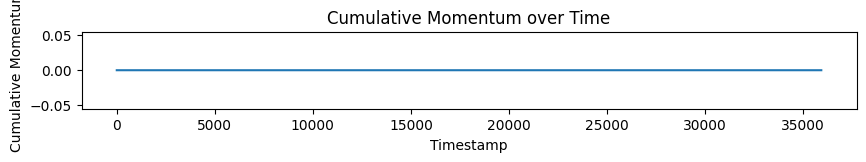

In [506]:
plot_cumulative_momentum(cumulative_momentum)

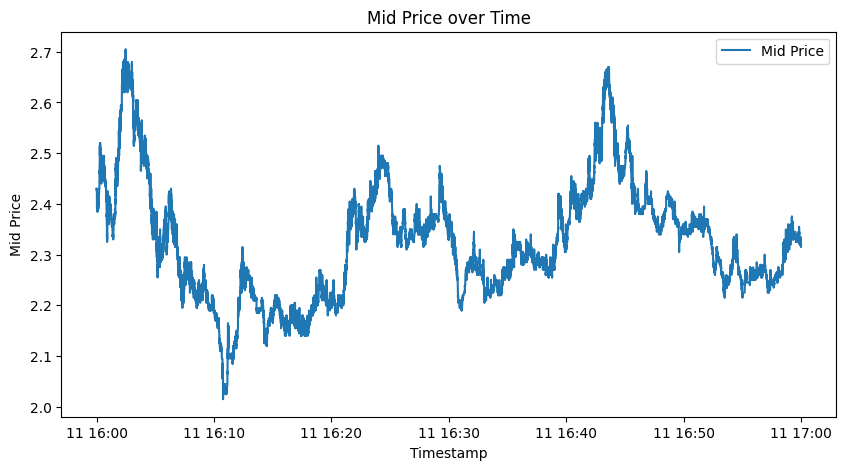

In [455]:
plot_mid_price(price_df, limit=100000)

In [ ]:
orders_df[orders_df.order_type == 'limit'].shape

(243751, 38)

In [ ]:
full_channel_df[full_channel_df.sequence >= 1292614427]

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
15678,NaN,NaN,11.525,2.42,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614427,NaN,7884870.0,57efb602-15ea-4cd5-baf8-b0a8239ea4b2,355a5570-2884-43bc-9caf-305ed5420435,NaN,NaN,NaN,NaN,1652284799959016000
15679,57efb602-15ea-4cd5-baf8-b0a8239ea4b2,NaN,NaN,2.42,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614428,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284799959016000
15680,NaN,NaN,28.646,2.42,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614429,NaN,7884871.0,2670fa8a-ef7c-40d2-98d5-7dbb69172559,355a5570-2884-43bc-9caf-305ed5420435,NaN,NaN,NaN,NaN,1652284799959016000
15681,2670fa8a-ef7c-40d2-98d5-7dbb69172559,NaN,NaN,2.42,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614430,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284799959016000
15682,NaN,NaN,14.000,2.42,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:59.959016+00:00,1292614431,NaN,7884872.0,fae9c58b-e1eb-4416-b47c-7e01a0c30e80,355a5570-2884-43bc-9caf-305ed5420435,NaN,NaN,NaN,NaN,1652284799959016000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768267,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,2.32,NaN,done,sell,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367016,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652288392921821000
768268,16efdc4e-f04e-43df-baf4-5ebb76c21285,limit,20.000,2.32,20220511-0000-0000-0004-000000552331,received,sell,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652288392935290000
768269,NaN,NaN,4.268,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367018,NaN,7922512.0,17bd2f80-a385-4ad4-b904-94537b6cb3c2,16efdc4e-f04e-43df-baf4-5ebb76c21285,NaN,NaN,NaN,NaN,1652288392935290000
768270,17bd2f80-a385-4ad4-b904-94537b6cb3c2,NaN,NaN,2.32,NaN,done,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367019,0.0,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652288392935290000


In [ ]:
full_channel_df[full_channel_df.order_type == 'limit'].shape

(248796, 19)

In [ ]:
orders_df[orders_df.order_type == 'limit'].shape

(30540, 34)

In [311]:
accum_df[accum_df.momentum.isna() & (accum_df.reason == 'filled')].shape

(191727, 12)

In [193]:
accum_df.velocity.notna().sum()

np.int64(29836)

In [28]:
full_channel_df.order_type.unique()

array(['limit', nan, 'market'], dtype=object)

In [ ]:
full_channel_df.type.unique()

array(['received', 'open', 'match', 'done', 'change'], dtype=object)

In [30]:
full_channel_df.reason.unique()

array([nan, 'filled', 'canceled'], dtype=object)

In [ ]:
ndf = full_channel_df.where(full_channel_df.order_type.isna())

In [46]:
full_channel_df[full_channel_df.order_type == 'market'].shape

(2360, 19)

In [ ]:
full_channel_df[full_channel_df.order_type == 'market'].shape

(2360, 19)

In [ ]:
full_channel_df[full_channel_df.type == 'match']

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
5,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598754,NaN,7884081.0,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
3,NaN,NaN,374.806,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598752,NaN,7884080.0,474813db-2329-4aba-a07b-b1adea78da8f,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,NaN,NaN,1652284740813739000
171,NaN,NaN,14.000,2.33,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:01.357997+00:00,1292598920,NaN,7884082.0,df4ec280-7d72-4f13-a79f-4f09bfeed96f,46fd14be-872e-4125-a5d2-b808f16e84b6,NaN,NaN,NaN,NaN,1652284741357997000
367,NaN,NaN,17.473,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:02.177983+00:00,1292599116,NaN,7884083.0,b1eb85bc-b2ef-40bf-b606-2d57c34b360b,d3126119-1c84-417e-826b-f24329f651a8,NaN,NaN,NaN,NaN,1652284742177983000
369,NaN,NaN,11.525,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 15:59:02.177983+00:00,1292599118,NaN,7884084.0,bb2fde8a-e60c-41eb-853d-65d788a2583b,d3126119-1c84-417e-826b-f24329f651a8,NaN,NaN,NaN,NaN,1652284742177983000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768261,NaN,NaN,0.428,2.33,NaN,match,sell,WLUNA-USD,2022-05-11 16:59:52.913315+00:00,1293367010,NaN,7922509.0,bd093610-4dd4-419c-9d2e-208ae2a465bf,cfbef5ba-ea97-4007-b79d-3209d85573ba,NaN,NaN,NaN,NaN,1652288392913315000
768264,NaN,NaN,13.771,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367013,NaN,7922510.0,76b22ba0-975e-4efa-be94-bf71ea5464ae,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,NaN,NaN,1652288392921821000
768266,NaN,NaN,6.229,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.921821+00:00,1293367015,NaN,7922511.0,17bd2f80-a385-4ad4-b904-94537b6cb3c2,22d3c8a0-3942-4315-aa07-a89f2d09f15e,NaN,NaN,NaN,NaN,1652288392921821000
768271,NaN,NaN,15.732,2.32,NaN,match,buy,WLUNA-USD,2022-05-11 16:59:52.935290+00:00,1293367020,NaN,7922513.0,6025f56a-f1a6-49a6-9dba-3c4c62af7272,16efdc4e-f04e-43df-baf4-5ebb76c21285,NaN,NaN,NaN,NaN,1652288392935290000


In [262]:
#maker_order_id
#811f8a8f-53dc-4b0b-b106-9f6cba1eef4b
#474813db-2329-4aba-a07b-b1adea78da8f

#taker_order_id
#0299ed2d-d33d-4313-a1d4-b74ce9cc9f26

In [ ]:
full_channel_df[(full_channel_df.order_id == '0299ed2d-d33d-4313-a1d4-b74ce9cc9f26') | (full_channel_df.order_id == '811f8a8f-53dc-4b0b-b106-9f6cba1eef4b') | (full_channel_df.order_id == '474813db-2329-4aba-a07b-b1adea78da8f')]

,order_id,order_type,size,price,client_oid,type,side,product_id,time,sequence,remaining_size,trade_id,maker_order_id,taker_order_id,reason,funds,old_size,new_size,timestamp
6,811f8a8f-53dc-4b0b-b106-9f6cba1eef4b,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598755,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000
2,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,limit,2324.238,2.33,b1f276a7-e271-4c82-9fa7-a55451507f82,received,sell,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1652284740813739000
7,0299ed2d-d33d-4313-a1d4-b74ce9cc9f26,NaN,NaN,2.33,NaN,done,sell,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598756,1935.432,NaN,NaN,NaN,canceled,NaN,NaN,NaN,1652284740813739000
4,474813db-2329-4aba-a07b-b1adea78da8f,NaN,NaN,2.33,NaN,done,buy,WLUNA-USD,2022-05-11 15:59:00.813739+00:00,1292598753,0.000,NaN,NaN,NaN,filled,NaN,NaN,NaN,1652284740813739000


When order_type is **NaN**, type can be **open**, **match**, **done**, **change** (order change/trade)  
When order_type is **limit** or **market**, type is **received** (order creation)  

When order_type is **NaN**, reason can be **NaN**, **filled**, **canceled** ()  
When order_type is **limit** or **market**, reason can be **NaN**  

